# Image Caption Generator
# # Image Caption Generator là gì?
* Image Caption Generator là quá trình tạo ra mô tả bằng văn bản cho một hình ảnh. Nó sử dụng cả xử lý Ngôn ngữ Tự nhiên(NLP) và Thị giác Máy tính(CV) để tạo ra các chú thích.
* Nhiệm vụ này nằm ở giao điểm của thị giác máy tính và xử lý ngôn ngữ tự nhiên. Hầu hết các hệ thống gắn chữ cho hình ảnh sử dụng khung mã hóa-giải mã, trong đó một hình ảnh đầu vào được mã hóa thành một biểu diễn trung gian của thông tin trong hình ảnh, sau đó được giải mã thành một chuỗi văn bản mô tả.
# # CNN + RNN (LSTM)
* Để thực hiện Gắn Chữ cho Hình Ảnh, chúng ta sẽ cần kết hợp hai mô hình học sâu thành một cho mục đích huấn luyện.
* CNNs trích xuất các đặc trưng từ hình ảnh thành một vector có kích thước nhất định, còn gọi là nhúng vector. Kích thước của các nhúng này phụ thuộc vào loại mạng được huấn luyện trước được sử dụng để trích xuất đặc trưng.
* LSTM được sử dụng cho quá trình tạo văn bản. Các nhúng hình ảnh được nối với các nhúng từ và truyền vào LSTM để tạo ra từ tiếp theo.
* Để có lời giải thích trực quan hơn về kiến trúc này, hãy xem phần Mô hình hóa để có hình ảnh biểu diễn.

In [15]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm

# NLP Imports
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding, LSTM, add,Input, Dense,Dropout, Concatenate, Reshape, concatenate, Bidirectional

# Model Creation Imports
from tensorflow.keras.models import Sequential, Model

# Computer Vision Imports
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201

# Model Learning & Losses Imports
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Warning & Vistualizatoin Imports
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

# Tải dữ liệu 

In [2]:
image_path = '/kaggle/input/flickr8k/Images'
data = pd.read_csv("/kaggle/input/flickr8k/captions.txt")
data.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

# Hình ảnh và chú thích tương ứng

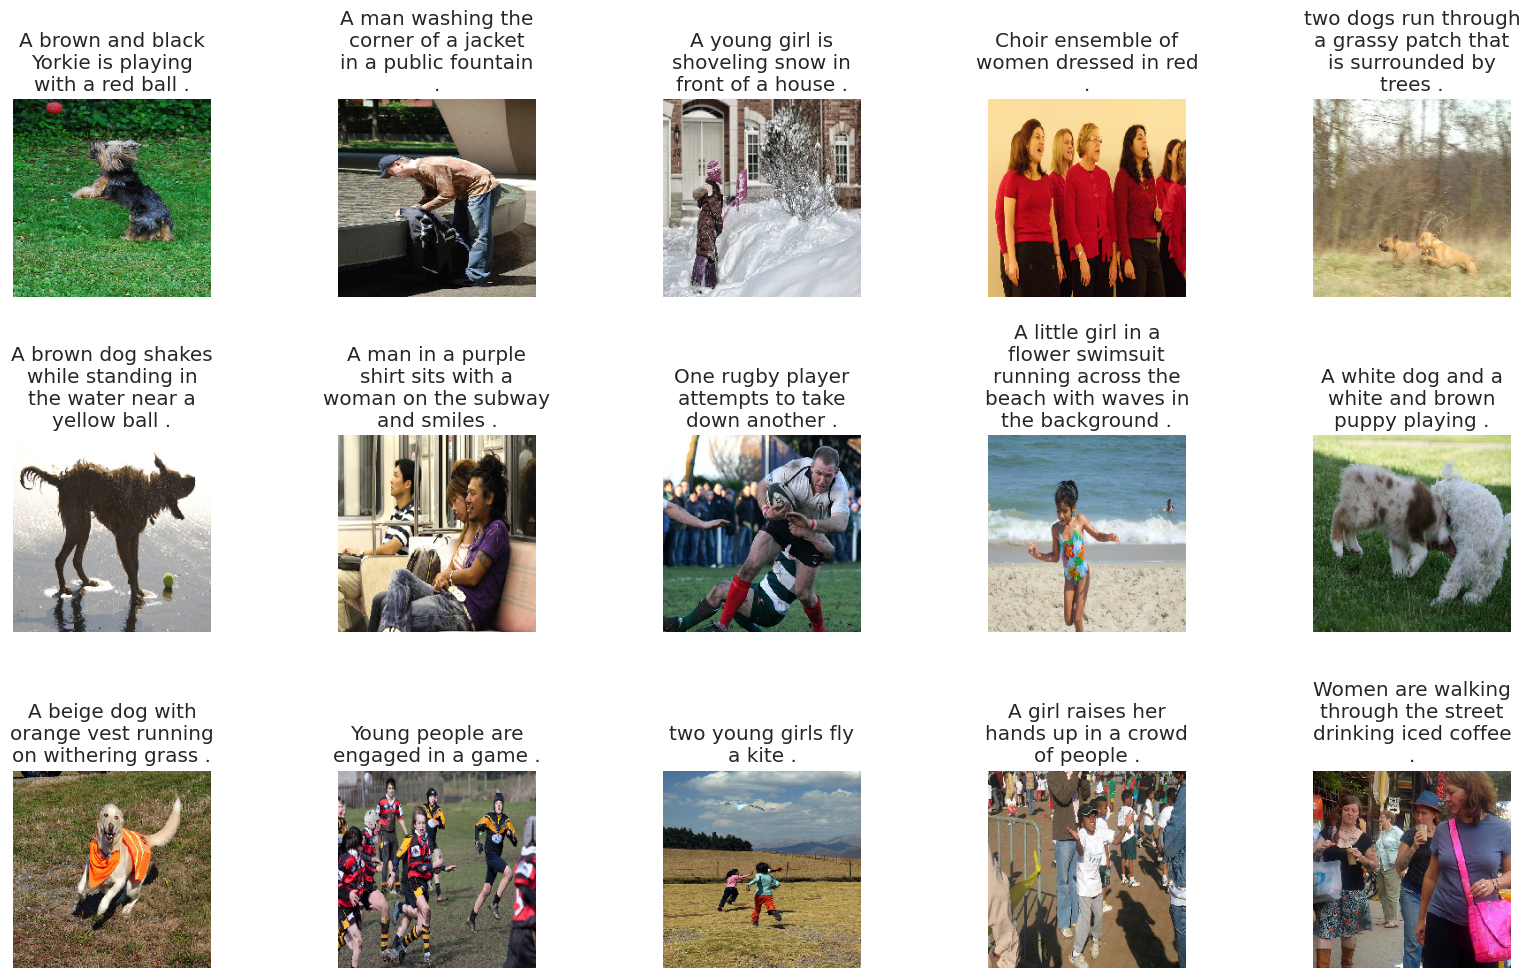

In [3]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"../input/flickr8k/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")
display_images(data.sample(15))

# Chú thích các bước tiền xử lý văn bản
* Chuyển các câu thành chữ thường
* Loại bỏ các ký tự đặc biệt và số có trong văn bản
* Loại bỏ khoảng trắng thừa
* Loại bỏ các ký tự đơn lẻ
* Thêm thẻ bắt đầu và thẻ kết thúc vào các câu để chỉ định điểm bắt đầu và điểm kết thúc của một câu

In [4]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"
    return data

data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

# Biểu diễn mã thông báo và được mã hóa

* Các từ trong câu được phân tách/mã thông báo và được mã hóa trong một biểu diễn nóng
* Những mã hóa này sau đó được chuyển đến lớp nhúng để tạo từ nhúng từ
  
  ![image](https://camo.githubusercontent.com/b6fc1884793314d6120857c161c5a604b43e2fa1e009a74e58c1b2a80142a3a8/68747470733a2f2f6c656e612d766f6974612e6769746875622e696f2f7265736f75726365732f6c656374757265732f776f72645f656d622f6c6f6f6b75705f7461626c652e676966)

In [5]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(captions)

vocab_size = len(tokenizer.word_index) + 1

max_length = max([len(caption.split()) for caption in captions])

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 18, 315, 63, 195, 116, 2]

# Khai thác tính năng hình ảnh

* Kiến trúc Densenet 201 được sử dụng để trích xuất các tính năng từ hình ảnh
* Bất kỳ kiến trúc trước nào khác cũng có thể được sử dụng để trích xuất các tính năng từ những hình ảnh này
* Do lớp gộp trung bình toàn cầu được chọn làm lớp cuối cùng của mô hình DENSENET201 để trích xuất tính năng của chúng tôi, việc nhúng hình ảnh của chúng tôi sẽ là một vectơ có kích thước 1920
  ![image](https://camo.githubusercontent.com/9e5b7fe2d3572c7151f817e6a3cb019f3690e5c627f6e2a5c3cd1b895f4a7164/68747470733a2f2f696d6775722e636f6d2f775748576251742e6a7067)

In [6]:
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

I0000 00:00:1747193295.912369      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


82524592/82524592 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


  0%|          | 0/8091 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1747193312.832744      93 service.cc:148] XLA service 0x7b6e640025f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747193312.833861      93 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747193314.964381      93 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1747193328.308277      93 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 8091/8091 [13:31<00:00,  9.97it/s]


# Tạo dữ liệu
* Vì đào tạo mô hình chú thích hình ảnh như bất kỳ đào tạo mạng thần kinh nào khác là một quy trình sử dụng tài nguyên cao,nên không thể tải dữ liệu vào bộ nhớ chính cùng một lúc và do đó chúng ta cần tạo dữ liệu theo định dạng yêu cầu
* Các đầu vào sẽ là hình ảnh nhúng và văn bản chú thích phù hợp của chúng cho quá trình đào tạo
* Các văn bản nhúng được truyền qua từng từ để tạo chú thích trong thời gian suy luận

In [7]:
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y


train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

# Mô hình hóa
* Các biểu diễn nhúng hình ảnh được kết hợp với từ đầu tiên của câu IE. Starseq và được chuyển đến mạng LSTM
* Mạng LSTM bắt đầu tạo các từ sau mỗi lần đầu vào do đó tạo thành một câu ở cuối

In [8]:
from tensorflow.keras.utils import plot_model

input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1,256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)

merged = concatenate([img_features_reshaped, sentence_features], axis =1)
sentence_features = LSTM(256)(merged)

x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation = 'softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

from tensorflow.keras.callbacks import ModelCheckpoint

# Define the model checkpoint
model_name = "model.keras"  
checkpoint = ModelCheckpoint(
    model_name,
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',patience=3, verbose=1,  factor=0.2, min_lr=0.00000001)

history = caption_model.fit(train_generator,epochs=50,validation_data=validation_generator,callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - loss: 5.6641
Epoch 1: val_loss improved from inf to 4.18273, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 286s 517ms/step - loss: 5.6629 - val_loss: 4.1827 - learning_rate: 0.0010
Epoch 2/50
536/537 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 4.2029
Epoch 2: val_loss improved from 4.18273 to 3.88868, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 75s 138ms/step - loss: 4.2026 - val_loss: 3.8887 - learning_rate: 0.0010
Epoch 3/50
536/537 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 3.9168
Epoch 3: val_loss improved from 3.88868 to 3.76175, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 75s 139ms/step - loss: 3.9167 - val_loss: 3.7617 - learning_rate: 0.0010
Epoch 4/50
536/537 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 3.7505
Epoch 4: val_loss improved from 3.76175 to 3.68186, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 73s 134ms/step - loss: 3.7504 - val_loss: 3.6819 - learning_rate: 0.0010

# Học đường cong
* Mô hình rõ ràng có quá mức, có thể là do lượng dữ liệu ít hơn
* Nên có thể giải quyết vấn đề này theo hai cách
  1. Huấn luyện mô hình trên bộ dữ liệu lớn hơn flickr40k
  2. Mô hình chú ý

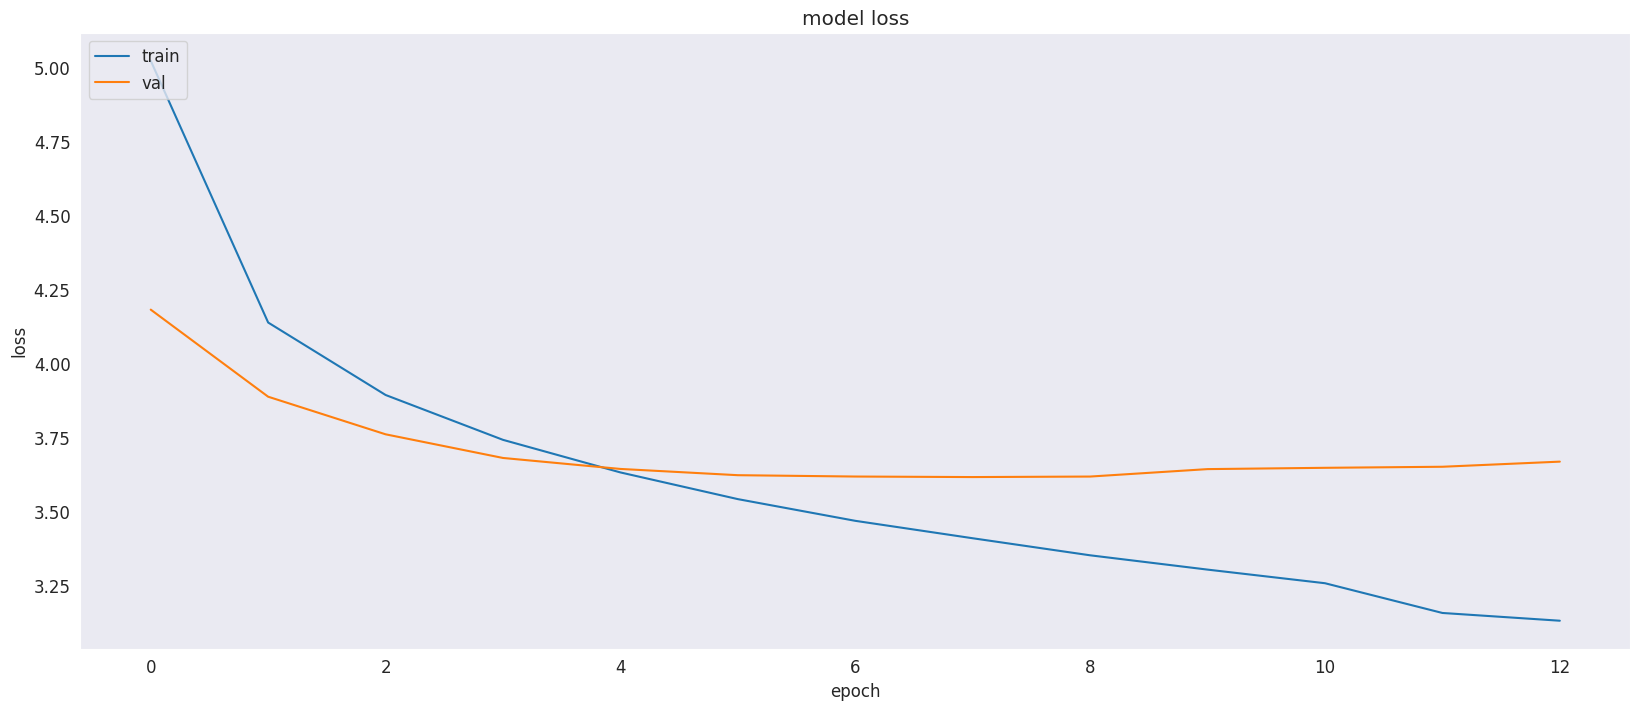

In [9]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Chú thích Chức năng Tiện ích Tạo
* Các chức năng tiện ích để tạo ra các chú thích của hình ảnh đầu vào tại thời điểm suy luận.
* Ở đây, hình ảnh nhúng được truyền cùng với từ đầu tiên, tiếp theo là văn bản nhúng của mỗi từ mới được truyền để tạo từ tiếp theo

In [16]:
# import pickle

# pickle.dump(tokenizer,open("tokenizer.pkl", 'wb'))
# pickle.dump(fe, open('feature_extractor.pkl', 'wb'))

In [10]:
import pickle

with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

fe.save("feature_extractor.keras")

In [11]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import pickle

# load save files
model_path = "model.keras"
tokenizer_path = "tokenizer.pkl"
feature_extractor_path = "feature_extractor.keras"

def generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path, max_length=34, img_size= 224):
    caption_model = load_model(model_path)
    feature_extractor = load_model(feature_extractor_path)

    with open(tokenizer_path, "rb") as f:
        tokenizer = pickle.load(f)


    img = load_img(image_path, target_size=(img_size, img_size))
    img = img_to_array(img) / 255.0 # Bình thường hóa các giá trị pixel
    img = np.expand_dims(img, axis=0)

    image_features = feature_extractor.predict(img, verbose=0)

    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([image_features,sequence], verbose=0)
        yhat_index = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat_index, None)
        if word is None:
            break
        in_text += " "+ word
        if word == 'endseq':
            break
    caption = in_text.replace('startseq','').replace("endseq",'').strip()

    img = load_img(image_path, target_size=(img_size, img_size))
    plt.figure(figsize=(8,8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(caption, fontsize=16, color='blue')
    plt.show()

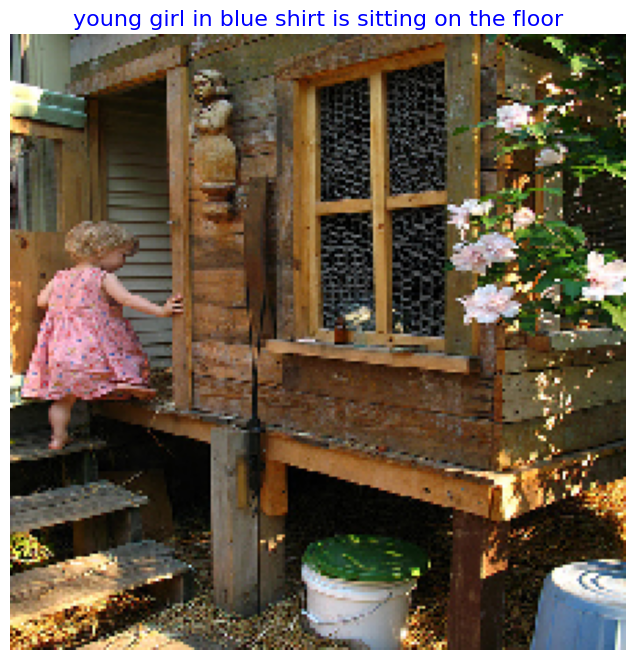

In [12]:
# Ví dụ sử dụng 
image_path = "/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg"  
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)

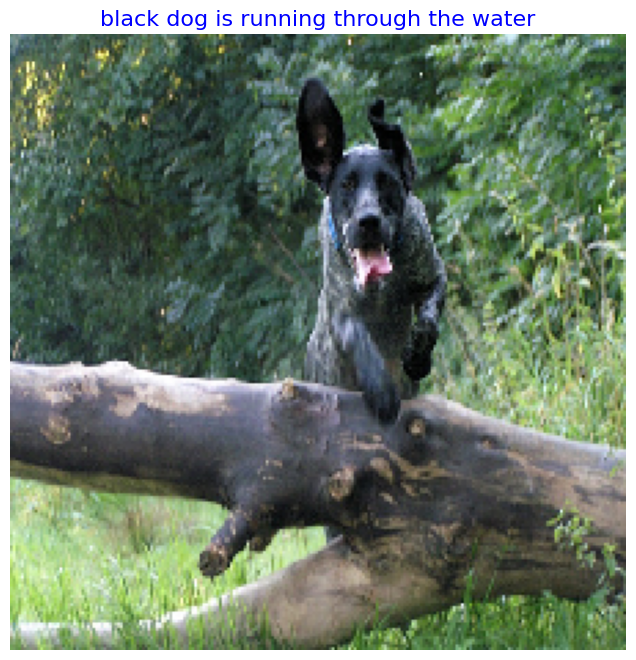

In [13]:
image_path = "/kaggle/input/flickr8k/Images/1015584366_dfcec3c85a.jpg"  
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)

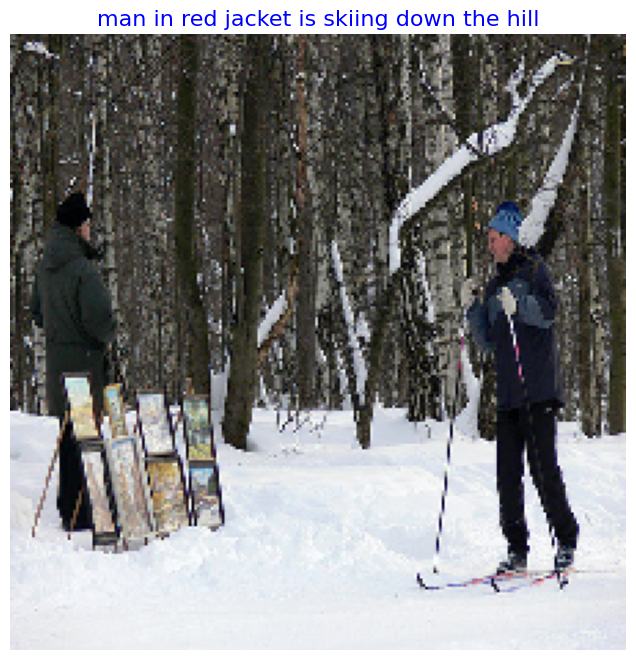

In [14]:
image_path = "/kaggle/input/flickr8k/Images/101669240_b2d3e7f17b.jpg"  
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)

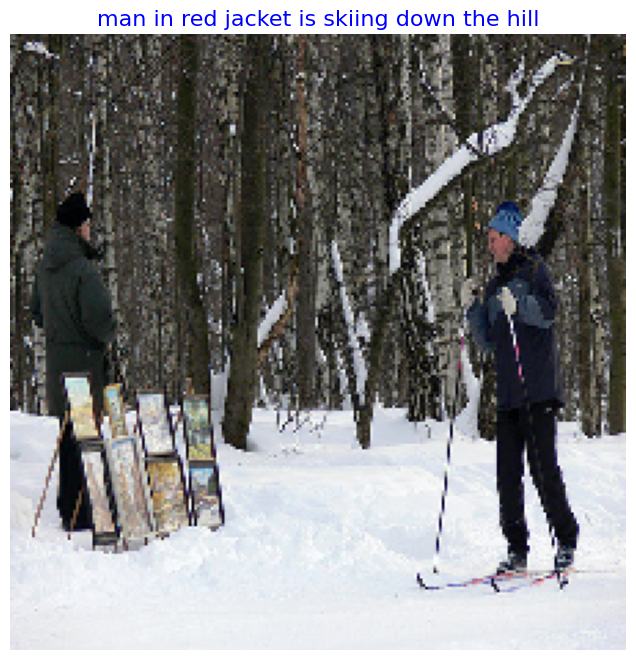

In [17]:
image_path = "/kaggle/input/flickr8k/Images/101669240_b2d3e7f17b.jpg"  
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)